<a href="https://colab.research.google.com/github/nicolafan/CLIP_prefix_caption/blob/main/captioning/vlp_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning a Vision-Language Pre-Trained Model with Hugging Face 🤗 and PyTorch

In this tutorial, we will learn how to fine-tune a pre-trained Vision-Language model (VLP) using Hugging Face and PyTorch. The fine-tuning process will be performed on a custom dataset of artistic images paired with corresponding captions. However, it's important to note that the ground truth captions are generated using ChatGPT, which means they may contain errors and hallucinations. To mitigate the effect of this noise, we will employ instance weighting.

## Advice

If you're running this notebook in Google Colab, we suggest selecting a GPU runtime (if you want to start the sample training).

## Setup

### Install Dependencies

In [1]:
! pip install -qq transformers datasets torch torchvision evaluate rouge_score onedrivedownloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00


### Imports

In [2]:
import os
from pathlib import Path
from transformers import AutoProcessor, AutoModelForCausalLM, BlipForConditionalGeneration, get_cosine_schedule_with_warmup
import requests
from datasets import load_from_disk
import torch
import re
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
import random
from evaluate import load
import torch
from torch.nn import functional as nnf
from PIL import Image
import numpy as np
from tqdm import tqdm
from onedrivedownloader import download

### Enable Reproducibility

In [3]:
# set all seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load the Model and Processor

Working with Hugging Face models typically requires instantiating the model using its name. Models are usually associated with their corresponding processors, which process the data before feeding it to the model. Hugging Face recommends using the `AutoProcessor` and `AutoModel*` classes for instantiation. This approach allows us to easily switch between models and processors without relying on specific classes used for the implementation of each model.

In this example, we will use Microsoft's [Generative Image-to-text Transformer (GIT)](https://huggingface.co/microsoft/git-base) as our pre-trained VLP model. This model utilizes a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224)  as the image encoder and a generic transformer as a decoder for language generation.

![img](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/git_architecture.jpg)

In [4]:
MODEL_NAME = "microsoft/git-base"
PROCESSOR = AutoProcessor.from_pretrained(MODEL_NAME)
MODEL = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

OUTPUT_DIR = "tutorial"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Our model is a type of `AutoModelForCausalLM`, used for language generation. Causal language modeling doesn't allow the transformer decoder to attend to tokens on the right.

Next, we load the model on the GPU (if it is available) by setting our device using Pytorch.

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL.to(DEVICE)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

## Data Preparation

In this section, we load our Hugging Face dataset, which consists of images and associated information, including the descriptions that serve as our ground truth. Utilizing a Hugging Face dataset is particularly advantageous when working with multimodal data, as it allows us to store all the data in a single folder and facilitates easy loading.

The images and their corresponding metadata are saved using [Arrow](https://arrow.apache.org/) in a columnar format, optimizing data reading and writing efficiency.

Each example in the dataset can be viewed as a row in a table, where the `image` column already contains the `PIL.Image` object, and the caption column contains the ground truth caption.

To create the Hugging Face dataset, we organize the images into folders for each split (train, validation, test). Additionally, we create a metadata file for each split. We then load the images and metadata using the `ImageFolder` dataset and save the loaded dataset to disk using `save_to_disk`, enabling easy reloading from a single folder.


### Load the Dataset

In [6]:
ln = "https://unibari-my.sharepoint.com/:u:/g/personal/n_fanelli10_studenti_uniba_it/Ed5uQ4sKTw9Eh7Z6l4AdHnEBA81ndM_LJtGC4MmcoxdOow?e=owoysr"
download(ln, filename="file.zip", unzip=True)

100%|██████████| 39.8M/39.8M [00:04<00:00, 8.51MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 14/14 [00:00<00:00, 56.59it/s]


''

In [7]:
DATASET = load_from_disk("artgraph_captioning_demo_dataset")
DATASET

DatasetDict({
    train: Dataset({
        features: ['image', 'clip_score', 'file_name', 'caption'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'clip_score', 'file_name', 'captions'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['image', 'clip_score', 'file_name', 'captions'],
        num_rows: 1000
    })
})

The dataset is composed of $116,475$ images from $\mathcal{A}rt\mathcal{G}raph$, and it has been split into `train`, `validation`, and `test` splits with a 70-15-15 proportion. Additionally, we randomly put $200$ of the human-annotated images in the training set and $300$ of them in the test set. Finally, we excluded from all sets the examples that had a CLIPScore of less than $0.15$.

We computed the CLIPScore of an image-text example $(I, T)$ as the cosine similarity between the CLIP embeddings of the image and the text:

$$CLIPScore(I, T) = \max(\cos(CLIP(I), CLIP(T)), 0)$$

This formula usually provides scores in the range $[0, 0.4]$, where examples with a score of $0.4$ are typically correct, and examples with a score of less than $0.15$ are usually completely incorrect (hence excluded from the sets). We excluded around $\sim 2000$ examples from the dataset using CLIPScore.

The splits contain the following number of examples:

* `train`: $80,127$
* `validation`: $17,128$
* `test`: $17,385$

In this tutorial each split contains $1,000$ samples to present the fine-tuning process.

### Caption Augmentation

Image captioning datasets such as MS COCO typically contain multiple ground truth captions for each image. This can help the model to generalize. However, in our case, we only have one ground truth caption for each image. To mitigate this issue, we employed caption augmentation using [back-translation](https://ieeexplore.ieee.org/document/9659834), generating two additional captions for each image.

We put the three image captions in the same row for the validation and test sets:

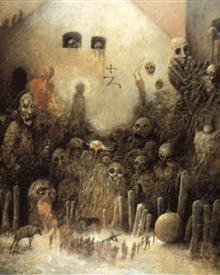

Captions:
a bleak, dystopian world with a massive, decaying structure dominating the landscape, and strange, skeletal structures in the foreground
a dark and dystopic world with a massive and decaying structure overlooking the landscape, and strange skeletal structures in the foreground
a bleak, dystopian world with a massive, decaying structure that dominates the landscape, and strange, skeletal structures in the foreground


In [8]:
validation_example = DATASET["validation"][400]
display(validation_example["image"])
print("Captions:")
for caption in validation_example["captions"]:
    print(caption)

Conversely, we put the three image captions in different rows for the training set, creating three different examples for each image (hence tripling the size of the training set i.e. $80,127 \times 3 = 240,381$):

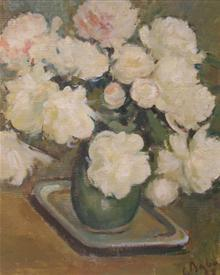

Example no. 400
Caption: white peonies in the green vase, showing a realistic still-life painting of flowers in a vase
Example no. 597
Caption: White Peonies in Green Vase, showing a realistic still life painting of flowers in a vase
Example no. 598
Caption: white peonies in green vase showing a realistic still life of flowers in a vase


In [9]:
training_example = DATASET["train"][400]
display(training_example["image"])
print("Example no. 400", f"Caption: {training_example['caption']}", sep="\n")

# show examples in DATASET["train"] having file_name equal to training_example["file_name"]
for i, example in enumerate(DATASET["train"].select(range(401, len(DATASET["train"])))):
    n_examples = 1
    if example["file_name"] == training_example["file_name"]:
        print(f"Example no. {i}", f"Caption: {example['caption']}", sep="\n")
        n_examples += 1
        if n_examples >= 3:
            break

### CLIPScore Examples

We used CLIPScore to evaluate the quality of our generated ground truth. Within the next cell we show some examples of bad, average and good image-caption pairs, according to the CLIPScore.

BAD EXAMPLES


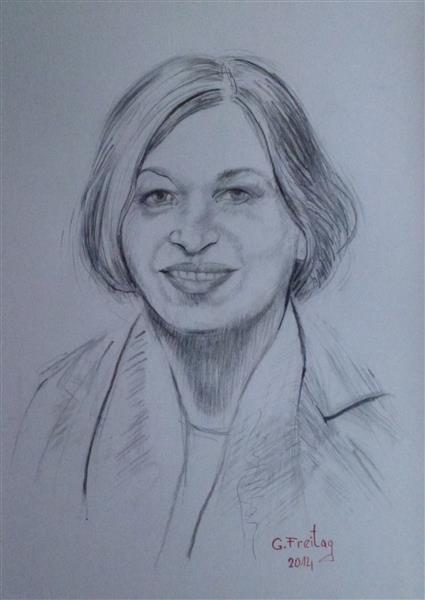

a woman named Ursula Pfeiffer, wearing a red sweater and glasses, with an urban landscape in the background
0.1853431693270759


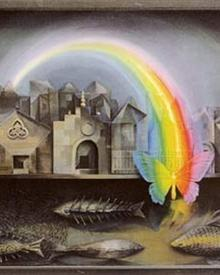

a landscape with a river and a bridge, with a colorful and abstract style and a sense of movement
0.19081939674383153


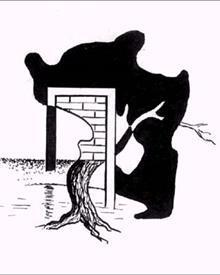

an abstract monochromatic composition with shades of grey and soft lines
0.19775535929005694

AVERAGE EXAMPLES


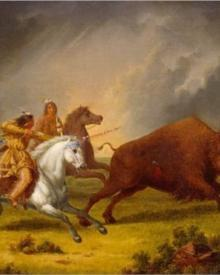

several native men on horseback, hunt a group of buffaloes with spears, bows and arrows, against a dramatic sky
0.2892312021993575


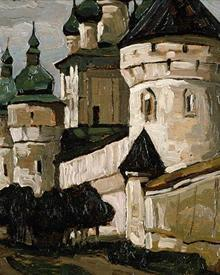

rostov the great, a Russian city, with its buildings and walls depicted in muted colors
0.2961177506185877


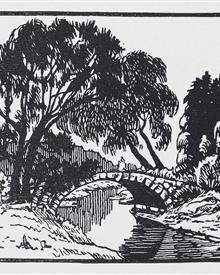

a group of grazing trees near the Novosilviysky bridge in Saint Petersburg, with a fence and a river visible in the background and a woman in the foreground on foot
0.2224078369814152

GOOD EXAMPLES


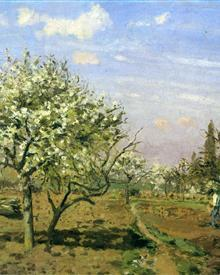

an orchard in blossom in Louveciennes
0.337843233162643


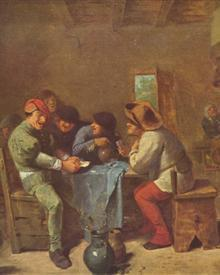

a group of peasants gathered around a table in a tavern, playing cards and smoking, while others watched them
0.35282614409045543


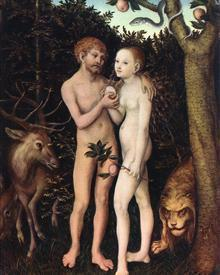

Adam and Eve standing in a garden, with a snake on a tree
0.32366077508077834


In [10]:
bad_examples, avg_examples, good_examples = [], [], []

for example in DATASET["train"]:
    if example["clip_score"] <= 0.2:
        if len(bad_examples) < 3:
            bad_examples.append(example)
    elif example["clip_score"] <= 0.3:
        if len(avg_examples) < 3:
            avg_examples.append(example)
    else:
        if len(good_examples) < 3:
            good_examples.append(example)
    if len(bad_examples) >= 3 and len(avg_examples) >= 3 and len(good_examples) >= 3:
        break

def show_examples_with_scores(examples):
    for example in examples:
        display(example["image"])
        print(example["caption"], example["clip_score"], sep="\n")

print("BAD EXAMPLES")
show_examples_with_scores(bad_examples)
print("\nAVERAGE EXAMPLES")
show_examples_with_scores(avg_examples)
print("\nGOOD EXAMPLES")
show_examples_with_scores(good_examples)


The examples suggest that CLIPScore is a good metric to evaluate the quality of the generated captions, as [other works](https://arxiv.org/abs/2104.08718) in the literature have shown.

### Transform the Examples

We will now set data transformations to the dataset, to make the examples ready to be fed to the model. We will use the `set_transform` method of the dataset, which allows us to apply a function to each example of the dataset.

Firstly, we define slight image augmentations to apply "on the fly" when feeding examples to the model for training.

In [11]:
augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=10),
])

Then, we define the data transformation for the training set:

In [12]:
def _transform_train(example_batch):
    images = [augment(x) for x in example_batch["image"]] # augment images

    captions = [x for x in example_batch["caption"]]
    clip_scores = torch.tensor([x for x in example_batch["clip_score"]])
    file_names = [x for x in example_batch["file_name"]]

    # process images and captions
    inputs = PROCESSOR(images=images, text=captions, padding="max_length", return_tensors="pt")

    # return full examples as dictionaries
    inputs.update({
        "clip_score": clip_scores,
        "file_name": file_names
    })
    return inputs

The transformation for the validation and test sets will be slightly different, since each example here already is associated with three captions, that we will use as references when evaluating the model:

In [13]:
def _transform_test(example_batch):
    images = [x for x in example_batch["image"]] # no augmentation

    captions_list = [x for x in example_batch["captions"]]
    clip_scores = torch.tensor([x for x in example_batch["clip_score"]])
    file_names = [x for x in example_batch["file_name"]]

    # process images and captions, but for each image we have multiple captions
    inputs_list = [
        PROCESSOR(images=image, text=captions, padding="max_length", return_tensors="pt")
        for image, captions in zip(images, captions_list)
    ]

    # we have a list of dictionaries, but we want a dictionary of lists
    inputs = {}
    for k in inputs_list[0].keys():
        inputs[k] = [x[k] if k != "pixel_values" else x[k].squeeze() for x in inputs_list]

    # return full examples as dictionaries
    inputs.update({
        "clip_score": clip_scores,
        "file_name": file_names
    })
    return inputs

Finally, we easily apply the transformations to the datasets:

In [14]:
DATASET["train"].set_transform(_transform_train)
DATASET["validation"].set_transform(_transform_test)

We denormalize one of the images to check if everything is ok and if the augmentations are working as expected; we can run this cell multiple times to see different augmentations.

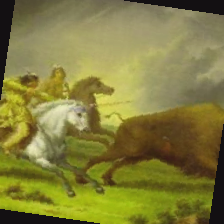

In [15]:
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (DATASET["train"][0]["pixel_values"].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

## Fine-Tuning the Model

We are ready to start training the model!

### Setup Training

Here we setup the training process. We will train the model for 5 epochs, with a batch size of 64. Unfortunately, this batch size is too large for our GPU, so we will have to use gradent accumulation to train the model. We set the real batch size to the number of examples that fit on the GPU, and then accumulate the gradients to simulate a batch size of 64. This technique can help you reproduce the results in papers that use a batch size that is too large for your GPU.

Our optimizer will be AdamW, while our learning rate scheduler will be a linear warmup with a cosine decay.

In [16]:
EPOCHS = 5

IDEAL_BATCH_SIZE = 64 # batch size you'd like to use
BATCH_SIZE = 1 # batch size that fits in memory
GRADIENT_ACCUMULATION_STEPS = IDEAL_BATCH_SIZE // BATCH_SIZE

In [17]:
optimizer = torch.optim.AdamW(MODEL.parameters(), lr=4.5e-7)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=(len(DATASET["train"]) // IDEAL_BATCH_SIZE) * EPOCHS)
epoch = 0

### Create DataLoaders

In [18]:
train_dataloader = DataLoader(DATASET["train"], batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(DATASET["validation"], batch_size=BATCH_SIZE)

It is also good practice to check some info about the model generation, such as the `pad_token_id`, especially if you're going to implement a custom training loop.

In [19]:
print(MODEL.generation_config)

GenerationConfig {
  "bos_token_id": 101,
  "eos_token_id": 102,
  "pad_token_id": 0
}



### Validation Evaluation

[🤗 Evaluate](https://huggingface.co/docs/evaluate/index) contains some metrics we can use to easily validate the model after each epoch. We load these metrics an apply them to the outputs of the model on the validation set.

In [20]:
bleu = load("bleu")
rouge = load("rouge")

In [21]:
@torch.no_grad()
def compute_metrics():
    all_decoded_predictions, all_decoded_labels = [], []

    for batch in tqdm(valid_dataloader):
        labels = batch.pop("input_ids").to(DEVICE)
        pixel_values = batch.pop("pixel_values").to(DEVICE)

        # generate model output
        generated_ids = MODEL.generate(pixel_values=pixel_values, max_length=50)

        # decode labels for each one of the three ground truth captions
        decoded_labels = []
        for label_group in labels:
            # a label_group is a set of three captions for the same image
            decoded_labels.append(PROCESSOR.batch_decode(label_group, skip_special_tokens=True))

        # decode the predictions
        decoded_predictions = PROCESSOR.batch_decode(generated_ids, skip_special_tokens=True)

        # add to the list of all decoded labels and predictions
        all_decoded_labels += decoded_labels
        all_decoded_predictions += decoded_predictions

    # compute metrics
    bleu1_score = bleu.compute(predictions=all_decoded_predictions, references=all_decoded_labels, max_order=1)
    bleu4_score = bleu.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    rouge_score = rouge.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    return {
        "bleu1_score": bleu1_score,
        "bleu4_score": bleu4_score,
        "rouge_score": rouge_score
    }

### Reload the Model

What if training fails for some reason? We can easily reload the model from the last checkpoint, and continue training from there.

In [22]:
# checkpoint = torch.load("tutorial/2.pt", map_location=torch.device("cpu"))
# MODEL.load_state_dict(checkpoint["model_state_dict"])
# MODEL.to(DEVICE)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
# epoch = checkpoint["epoch"] + 1

We won't need this code this time.

### Training Loop

In [23]:
# number of image tokens used as a prefix for the decoder
num_image_tokens = MODEL.git.encoder.layer[0].attention.self.image_patch_tokens

In [24]:
while epoch < EPOCHS:
    MODEL.train(True)
    print("Epoch:", epoch)
    running_loss = 0.0

    for step, batch in enumerate(tqdm(train_dataloader), start=1):
        # get batch data and move it to the correct device
        input_ids = batch.pop("input_ids").to(DEVICE)
        labels = input_ids  # labels are the same as the input_ids
        pixel_values = batch.pop("pixel_values").to(DEVICE)
        attention_mask = batch.pop("attention_mask").to(DEVICE)
        clip_scores = batch.pop("clip_score").to(DEVICE)

        # compute instance weights using the clip_scores
        clip_weights = (clip_scores * 8) - 1 / 5

        # forward pass
        outputs = MODEL(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
        )
        logits = outputs.logits  # we are only interested in the logits

        # compute the loss

        # we are not interested in the last token of the logits, so we discard it
        shifted_logits = logits[:, num_image_tokens:-1, :].contiguous()

        # shift the labels that are equal to the input_ids, so that we want to predict
        # the 2 token given the 1 token, the 3 token given the 2 token, etc.
        labels = labels[:, 1:].contiguous()

        # to compute the CE loss we need to have logits of shape (batch_size, vocab_size, seq_len)
        shifted_logits = shifted_logits.permute(0, 2, 1)

        # compute the CE loss, without reducing it on the time dimension, ignore padding
        losses = nnf.cross_entropy(
            shifted_logits, labels, ignore_index=0, reduction="none"
        )

        # compute the average loss for each instance, ignore padding
        losses = losses.sum(dim=1) / (labels != 0).sum(dim=1)

        # weight the instance loss
        weighted_losses = losses * clip_weights

        # divide by the no. of gradient accumulation steps
        loss = weighted_losses.mean() / GRADIENT_ACCUMULATION_STEPS
        running_loss += loss.item()

        # compute gradients
        loss.backward()

        # gradient accumulation
        if step % GRADIENT_ACCUMULATION_STEPS == 0:
            # backpropagation
            optimizer.step()
            # update learning rate
            scheduler.step()
            # reset gradients
            optimizer.zero_grad()

    # evaluate and save checkpoint
    MODEL.train(False)

    # save checkpoint
    avg_loss = running_loss / (len(DATASET["train"]) // IDEAL_BATCH_SIZE)
    print("Loss:", avg_loss)
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": MODEL.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "loss": avg_loss,
        },
        os.path.join(OUTPUT_DIR, f"{epoch}.pt"),
    )

    # compute metrics
    metrics = compute_metrics()
    metrics["loss"] = avg_loss
    with open(os.path.join(OUTPUT_DIR, f"{epoch}_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)

    # next epoch!
    epoch += 1

Epoch: 0


 33%|███▎      | 332/1000 [01:17<02:36,  4.27it/s]


KeyboardInterrupt: ignored

In this example our GPU has a restricted amount of memory (4GB), so training fails at the first backpropagation step (if you're running in Google Colab with a GPU runtime this problem won't happen).

## Conclusion

In this tutorial we have seen how to fine-tune a Hugging Face model for vision and language. We used multiple techniques to improve the effects of the training process, such as gradient accumulation, learning rate scheduling, instance weighting and data augmentation.

Are you ready to see the results? Let's go!